# Import libraries and load data

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, log_loss
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
from scipy.stats import uniform, randint
from sklearn import tree
from lightgbm import LGBMClassifier

In [2]:

db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "vnstockdw",
    "user": "postgres",
    "password": "postgres"
}

table_name = "stock_history"
table_schema = "public"

conn = psycopg2.connect(**db_params)

cur = conn.cursor()

cur.execute(f"SELECT * FROM {table_name}")

rows = cur.fetchall()

col_names = [desc[0] for desc in cur.description]

stock_df = pd.DataFrame(rows, columns=col_names)

cur.close()
conn.close()

### Data columns

In [3]:
stock_df.columns

Index(['created_at', 'updated_at', 'status', 'symbol', 'open', 'high', 'low',
       'close', 'volume', 'date', 'price_change_to_1_day(s)_ago',
       'price_change_to_2_day(s)_ago', 'price_change_to_3_day(s)_ago',
       'volume_change_to_1_day(s)_ago', 'volume_change_to_2_day(s)_ago',
       'volume_change_to_3_day(s)_ago', 'price_difference',
       'median_volume_3_day(s)_periods', 'std_volume_3_day(s)_periods',
       'median_price_change_3_day(s)_periods',
       'std_price_change_3_day(s)_periods',
       'median_volume_change_3_day(s)_periods',
       'std_volume_change_3_day(s)_periods', 'sma_3_days', 'sma_5_days',
       'wma_3_days', 'wma_5_days', 'ema_3_days', 'ema_5_days',
       'bool_sma_3_days', 'bool_sma_5_days', 'bool_wma_3_days',
       'bool_wma_5_days', 'bool_ema_3_days', 'bool_ema_5_days',
       'macd_of_ema3_and_ema5', '%k_3_days', '%k_5_days', '%d_3_days',
       '%d_5_days', 'rsi_3_days', 'rsi_5_days', 'williams_%r_3_days',
       'ad_3_days', 'cci_3_days', 'b

### Data shape

In [4]:
stock_df.shape

(177796, 60)

# Label Creation

In [5]:
stock_df.date.value_counts()

date
2023-08-18    1111
2023-09-08    1107
2023-08-11    1103
2023-06-23    1102
2023-07-28    1100
              ... 
2024-01-15      63
2024-01-10      63
2024-01-09      63
2024-01-17      62
2024-01-16      62
Name: count, Length: 195, dtype: int64

In [6]:
stock_df.head()

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_%d_5_days,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,NaN,NaN,1.0,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,NaN,-1.0,1.0,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,NaN,-1.0,1.0,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333
4,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,1074000.0,2023-05-10,...,1.0,-1.0,1.0,0.000000,0.022500,0.0,0.0,0.200000,0.400000,0.300000


In [7]:
grouped_df = stock_df.groupby(['date', 'symbol'])
print("Columns with different dates and symbol:", len(grouped_df))

Columns with different dates and symbol: 177796


In [8]:
DIVISION_THRESHOLD = 0

stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df['label_3_days'] = None
stock_df['label_4_days'] = None
stock_df['label_5_days'] = None

for offset_days in [3, 4, 5]:
    stock_df[f'future_date_{offset_days}_days'] = stock_df['date'] + pd.DateOffset(days=offset_days)

    merged_df = stock_df.merge(stock_df, how='left', left_on=['symbol', f'future_date_{offset_days}_days'], right_on=['symbol', 'date'], suffixes=('', '_future'))

    merged_df[f'price_difference_{offset_days}_days'] = merged_df['close_future'] - merged_df['close']
    merged_df[f'label_{offset_days}_days'] = np.where(merged_df[f'price_difference_{offset_days}_days'] > DIVISION_THRESHOLD, 1, 0)
    merged_df.loc[merged_df['close_future'].isnull(), f'label_{offset_days}_days'] = None

    stock_df[f'label_{offset_days}_days'] = merged_df[f'label_{offset_days}_days']

    stock_df.drop([f'future_date_{offset_days}_days'], axis=1, inplace=True)

stock_df.head()

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label_3_days,label_4_days,label_5_days
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000,1.0,1.0,1.0
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333,1.0,1.0,NaN
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333,1.0,NaN,NaN
4,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,1074000.0,2023-05-10,...,0.000000,0.022500,0.0,0.0,0.200000,0.400000,0.300000,NaN,NaN,1.0


In [52]:
# stock_df['date'] = pd.to_datetime(stock_df['date'])

# stock_df['label'] = None

# for index, row in stock_df.iterrows():
#     future_rows = stock_df[(stock_df['date'] == row['date'] + pd.DateOffset(days=3)) & (stock_df['symbol'] == row['symbol'])]
#     if not future_rows.empty:
#         future_row = future_rows.iloc[0] 
#         price_difference = future_row['close'] - row['close']
#         if price_difference > 0:
#             stock_df.at[index, 'label'] = 1
#         else:
#             stock_df.at[index, 'label'] = 0

# stock_df.head()

In [53]:
# stock_df.to_csv('stock_data_transformed.csv', index=False)

In [54]:
# stock_df = pd.read_csv('stock_data_transformed.csv')

Check transformation integrity

In [9]:
sample_rows = stock_df.sample(5) 

for index, sample_row in sample_rows.iterrows():
    symbol = sample_row['symbol']
    sample_date = sample_row['date']
    close = sample_row['close']
    label3 = sample_row['label_3_days']
    label4 = sample_row['label_4_days']
    label5 = sample_row['label_5_days']

    
    print(f"Sample Date: {sample_date}, Symbol: {symbol}, Close: {close}, Label 3: {label3}, Label 4: {label4}, Label 5: {label5}")

    for offset_days in [3, 4, 5]:
        future_date = sample_date + pd.DateOffset(days=offset_days)
        future_records = stock_df[(stock_df['date'] == future_date) & (stock_df['symbol'] == symbol)]
        
        if not future_records.empty:
            future_close = future_records.iloc[0]['close']
            future_label = future_records.iloc[0][f'label_{offset_days}_days']
            print(f"Records {offset_days} Days Later:")
            print(f"Symbol: {symbol}, Date: {future_date}, Close: {future_close}, Label: {future_label}")
        else:
            print(f"No records found {offset_days} days later for symbol {symbol} on date {future_date}")
    
        print()


Sample Date: 2023-05-12 00:00:00, Symbol: BBC, Close: 53240.0, Label 3: 1.0, Label 4: 1.0, Label 5: 1.0
Records 3 Days Later:
Symbol: BBC, Date: 2023-05-15 00:00:00, Close: 56910.0, Label: 1.0

Records 4 Days Later:
Symbol: BBC, Date: 2023-05-16 00:00:00, Close: 54390.0, Label: nan

Records 5 Days Later:
Symbol: BBC, Date: 2023-05-17 00:00:00, Close: 55360.0, Label: 1.0

Sample Date: 2023-12-01 00:00:00, Symbol: DNP, Close: 22200.0, Label 3: 1.0, Label 4: nan, Label 5: nan
Records 3 Days Later:
Symbol: DNP, Date: 2023-12-04 00:00:00, Close: 22500.0, Label: nan

No records found 4 days later for symbol DNP on date 2023-12-05 00:00:00

No records found 5 days later for symbol DNP on date 2023-12-06 00:00:00

Sample Date: 2023-12-14 00:00:00, Symbol: PGS, Close: 27400.0, Label 3: nan, Label 4: 1.0, Label 5: 1.0
No records found 3 days later for symbol PGS on date 2023-12-17 00:00:00

Records 4 Days Later:
Symbol: PGS, Date: 2023-12-18 00:00:00, Close: 29800.0, Label: nan

Records 5 Days L

In [10]:
filtered_df_3_days = stock_df.dropna(subset=['label_3_days'])
filtered_df_3_days['label_3_days'] = filtered_df_3_days['label_3_days'].astype(int)
print(filtered_df_3_days.shape)
filtered_df_3_days.head()

(90079, 63)


/var/folders/x1/372sp1hn2fs8wfj7nl_xj3s80000gn/T/ipykernel_85070/175587004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_3_days['label_3_days'] = filtered_df_3_days['label_3_days'].astype(int)


,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label_3_days,label_4_days,label_5_days
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000,1,1.0,1.0
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333,1,1.0,NaN
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333,1,NaN,NaN
6,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8090.0,1052500.0,2023-05-12,...,0.011125,0.011125,0.0,1052500.0,0.166667,0.500000,0.300000,1,1.0,1.0
7,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8090.0,8640.0,8000.0,8360.0,4371800.0,2023-05-15,...,0.032297,0.043062,0.0,4371800.0,0.166667,0.500000,0.300000,0,0.0,NaN


In [11]:
filtered_df_4_days = stock_df.dropna(subset=['label_4_days'])
filtered_df_4_days['label_4_days'] = filtered_df_4_days['label_4_days'].astype(int)
print(filtered_df_4_days.shape)
filtered_df_4_days.head()

(88258, 63)


/var/folders/x1/372sp1hn2fs8wfj7nl_xj3s80000gn/T/ipykernel_85070/487690454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_4_days['label_4_days'] = filtered_df_4_days['label_4_days'].astype(int)


,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label_3_days,label_4_days,label_5_days
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000,1.0,1,1.0
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333,1.0,1,NaN
5,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,906000.0,2023-05-11,...,0.000000,0.000000,0.0,0.0,0.166667,0.500000,0.300000,NaN,1,1.0
6,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8090.0,1052500.0,2023-05-12,...,0.011125,0.011125,0.0,1052500.0,0.166667,0.500000,0.300000,1.0,1,1.0


In [12]:
filtered_df_5_days = stock_df.dropna(subset=['label_5_days'])
filtered_df_5_days['label_5_days'] = filtered_df_5_days['label_5_days'].astype(int)
print(filtered_df_5_days.shape)
filtered_df_5_days.head()

(88402, 63)


/var/folders/x1/372sp1hn2fs8wfj7nl_xj3s80000gn/T/ipykernel_85070/3054340140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_5_days['label_5_days'] = filtered_df_5_days['label_5_days'].astype(int)


,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label_3_days,label_4_days,label_5_days
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,0.011643,NaN,NaN,786100.0,0.500000,0.5,0.5,1.0,1.0,1
4,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,1074000.0,2023-05-10,...,0.000000,0.022500,0.0,0.0,0.200000,0.4,0.3,NaN,NaN,1
5,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,906000.0,2023-05-11,...,0.000000,0.000000,0.0,0.0,0.166667,0.5,0.3,NaN,1.0,1
6,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8090.0,1052500.0,2023-05-12,...,0.011125,0.011125,0.0,1052500.0,0.166667,0.5,0.3,1.0,1.0,1


# EDA?

In [13]:
label_counts_3_days = filtered_df_3_days['label_3_days'].value_counts()
label_counts_4_days = filtered_df_4_days['label_4_days'].value_counts()
label_counts_5_days = filtered_df_5_days['label_5_days'].value_counts()

print("Label counts for 3 days:")
print(label_counts_3_days)

print("Label counts for 4 days:")
print(label_counts_4_days)

print("Label counts for 5 days:")
print(label_counts_5_days)

Label counts for 3 days:
label_3_days
0    50096
1    39983
Name: count, dtype: int64
Label counts for 4 days:
label_4_days
0    48665
1    39593
Name: count, dtype: int64
Label counts for 5 days:
label_5_days
0    47852
1    40550
Name: count, dtype: int64


# Models Training

## Split data

In [14]:
X_3_days = filtered_df_3_days.drop(columns=['label_3_days', 'label_4_days', 'label_5_days', 'created_at', 'updated_at', 'status', 'symbol', 'date'], axis=1)
y_3_days = filtered_df_3_days["label_3_days"]

X_train_3_days, X_test_3_days, y_train_3_days, y_test_3_days = train_test_split(X_3_days, y_3_days, random_state=0, test_size=0.2, stratify=y_3_days)

X_4_days = filtered_df_4_days.drop(columns=['label_3_days', 'label_4_days', 'label_5_days', 'created_at', 'updated_at', 'status', 'symbol', 'date'], axis=1)
y_4_days = filtered_df_4_days["label_4_days"]

X_train_4_days, X_test_4_days, y_train_4_days, y_test_4_days = train_test_split(X_4_days, y_4_days, random_state=0,  test_size=0.2, stratify=y_4_days)

X_5_days = filtered_df_5_days.drop(columns=['label_3_days', 'label_4_days', 'label_5_days', 'created_at', 'updated_at', 'status', 'symbol', 'date'], axis=1)
y_5_days = filtered_df_5_days["label_5_days"]

X_train_5_days, X_test_5_days, y_train_5_days, y_test_5_days = train_test_split(X_5_days, y_5_days, random_state=0,  test_size=0.2, stratify=y_5_days)

print("For 3 days:")
print("X_train shape:", X_train_3_days.shape)
print("X_test shape:", X_test_3_days.shape)
print("y_train shape:", y_train_3_days.shape)
print("y_test shape:", y_test_3_days.shape)

print("\nFor 4 days:")
print("X_train shape:", X_train_4_days.shape)
print("X_test shape:", X_test_4_days.shape)
print("y_train shape:", y_train_4_days.shape)
print("y_test shape:", y_test_4_days.shape)

print("\nFor 5 days:")
print("X_train shape:", X_train_5_days.shape)
print("X_test shape:", X_test_5_days.shape)
print("y_train shape:", y_train_5_days.shape)
print("y_test shape:", y_test_5_days.shape)


For 3 days:
X_train shape: (72063, 55)
X_test shape: (18016, 55)
y_train shape: (72063,)
y_test shape: (18016,)

For 4 days:
X_train shape: (70606, 55)
X_test shape: (17652, 55)
y_train shape: (70606,)
y_test shape: (17652,)

For 5 days:
X_train shape: (70721, 55)
X_test shape: (17681, 55)
y_train shape: (70721,)
y_test shape: (17681,)


In [15]:
#For models that cannot take -1
# For 3 days
y_mod_train_3_days = y_train_3_days.replace(0, -1)
y_mod_test_3_days = y_test_3_days.replace(0, -1)

# For 4 days
y_mod_train_4_days = y_train_4_days.replace(0, -1)
y_mod_test_4_days = y_test_4_days.replace(0, -1)

# For 5 days
y_mod_train_5_days = y_train_5_days.replace(0, -1)
y_mod_test_5_days = y_test_5_days.replace(0, -1)

## Benchmark models
### Dummy model

In [16]:
def evaluate_dummy_classifier(X_train, y_train, X_test, y_test):
    # Fit the Dummy Classifier
    dummy_majority = DummyClassifier(strategy='stratified').fit(X_train, y_train)

    # Evaluate the Dummy Classifier
    dummy_score = dummy_majority.score(X_test, y_test)
    print("Dummy Classifier Test Accuracy:", dummy_score)

    y_dummy_predictions = dummy_majority.predict(X_test)
    print(classification_report(y_test, y_dummy_predictions, target_names=['not 1', '1']))

    dummy_auc = roc_auc_score(y_test, y_dummy_predictions)
    print("Dummy Classifier Test AUC:", dummy_auc)

# For 3 days
print("For 3 days:")
evaluate_dummy_classifier(X_train_3_days, y_mod_train_3_days, X_test_3_days, y_mod_test_3_days)

# For 4 days
print("\nFor 4 days:")
evaluate_dummy_classifier(X_train_4_days, y_mod_train_4_days, X_test_4_days, y_mod_test_4_days)

# For 5 days
print("\nFor 5 days:")
evaluate_dummy_classifier(X_train_5_days, y_mod_train_5_days, X_test_5_days, y_mod_test_5_days)


For 3 days:
Dummy Classifier Test Accuracy: 0.5156527531083481
              precision    recall  f1-score   support

       not 1       0.56      0.56      0.56     10019
           1       0.44      0.44      0.44      7997

    accuracy                           0.51     18016
   macro avg       0.50      0.50      0.50     18016
weighted avg       0.51      0.51      0.51     18016

Dummy Classifier Test AUC: 0.5001004968139627

For 4 days:
Dummy Classifier Test Accuracy: 0.511103557670519
              precision    recall  f1-score   support

       not 1       0.55      0.55      0.55      9733
           1       0.45      0.45      0.45      7919

    accuracy                           0.50     17652
   macro avg       0.50      0.50      0.50     17652
weighted avg       0.50      0.50      0.50     17652

Dummy Classifier Test AUC: 0.4979061085030161

For 5 days:
Dummy Classifier Test Accuracy: 0.5105480459250042
              precision    recall  f1-score   support

       no

## Decision Tree

In [17]:
def print_model_evaluation_metrics(clf, X_train, y_train, X_test, y_test):
    # Train Accuracy
    train_accuracy = clf.score(X_train, y_train)
    print("Train Accuracy: {:.3f}".format(train_accuracy))

    # Test Accuracy
    test_accuracy = clf.score(X_test, y_test)
    print("Test Accuracy: {:.3f}".format(test_accuracy))

    # Train AUC
    y_train_predicted = clf.predict(X_train)
    train_auc = roc_auc_score(y_train, y_train_predicted)
    print('Train AUC: {:.3f}'.format(train_auc))

    # Test AUC
    y_test_predicted = clf.predict(X_test)
    test_auc = roc_auc_score(y_test, y_test_predicted)
    print('Test AUC: {:.3f}'.format(test_auc))

    # Log Loss
    y_test_predicted_proba = clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_predicted_proba)
    print('Test Log Loss: {:.3f}'.format(test_log_loss))

    # Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_test_predicted, target_names=['not 1', '1']))

In [18]:
def cross_val_scores(tree_clf, X, y, cv=5):
    scoring_metrics = ['neg_log_loss', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    cv_results = {'Metric': [], 'Cross-validated Scores': [], 'Mean Cross-validated Score': []}
    
    for metric in scoring_metrics:
        cv_scores = cross_val_score(tree_clf, X, y, cv=cv, scoring=metric)
        cv_results['Metric'].append(metric.capitalize())
        cv_results['Cross-validated Scores'].append(cv_scores)
        mean_score = cv_scores.mean()
        cv_results['Mean Cross-validated Score'].append('{:.3f}'.format(mean_score))
            
    df = pd.DataFrame(cv_results)
    
    return df

In [19]:
tree_clf = DecisionTreeClassifier().fit(X_train_3_days, y_train_3_days)
print_model_evaluation_metrics(tree_clf, X_train_3_days, y_train_3_days, X_test_3_days, y_test_3_days)

Train Accuracy: 1.000
Test Accuracy: 0.534
Train AUC: 1.000
Test AUC: 0.529
Test Log Loss: 16.791
Classification Report:
              precision    recall  f1-score   support

       not 1       0.58      0.57      0.58     10019
           1       0.48      0.49      0.48      7997

    accuracy                           0.53     18016
   macro avg       0.53      0.53      0.53     18016
weighted avg       0.54      0.53      0.53     18016



In [20]:
tree_clf = DecisionTreeClassifier(max_depth=3).fit(X_train_3_days, y_train_3_days)
print_model_evaluation_metrics(tree_clf, X_train_3_days, y_train_3_days, X_test_3_days, y_test_3_days)

Train Accuracy: 0.587
Test Accuracy: 0.580
Train AUC: 0.553
Test AUC: 0.546
Test Log Loss: 0.676
Classification Report:
              precision    recall  f1-score   support

       not 1       0.58      0.85      0.69     10019
           1       0.56      0.24      0.34      7997

    accuracy                           0.58     18016
   macro avg       0.57      0.55      0.52     18016
weighted avg       0.58      0.58      0.54     18016



[Text(0.5, 0.875, 'x[37] <= -75.021\ngini = 0.494\nsamples = 72063\nvalue = [40077.0, 31986.0]'),
 Text(0.25, 0.625, 'x[30] <= -50.141\ngini = 0.496\nsamples = 17841\nvalue = [8090, 9751]'),
 Text(0.125, 0.375, 'x[12] <= 11750.0\ngini = 0.483\nsamples = 9587\nvalue = [3912, 5675]'),
 Text(0.0625, 0.125, 'gini = 0.465\nsamples = 4621\nvalue = [1698, 2923]'),
 Text(0.1875, 0.125, 'gini = 0.494\nsamples = 4966\nvalue = [2214.0, 2752.0]'),
 Text(0.375, 0.375, 'x[39] <= -99.504\ngini = 0.5\nsamples = 8254\nvalue = [4178, 4076]'),
 Text(0.3125, 0.125, 'gini = 0.498\nsamples = 3366\nvalue = [1580.0, 1786.0]'),
 Text(0.4375, 0.125, 'gini = 0.498\nsamples = 4888\nvalue = [2598, 2290]'),
 Text(0.75, 0.625, 'x[4] <= 115650.0\ngini = 0.484\nsamples = 54222\nvalue = [31987.0, 22235.0]'),
 Text(0.625, 0.375, 'x[37] <= -40.535\ngini = 0.472\nsamples = 33209\nvalue = [20552, 12657]'),
 Text(0.5625, 0.125, 'gini = 0.49\nsamples = 12913\nvalue = [7350, 5563]'),
 Text(0.6875, 0.125, 'gini = 0.455\nsample

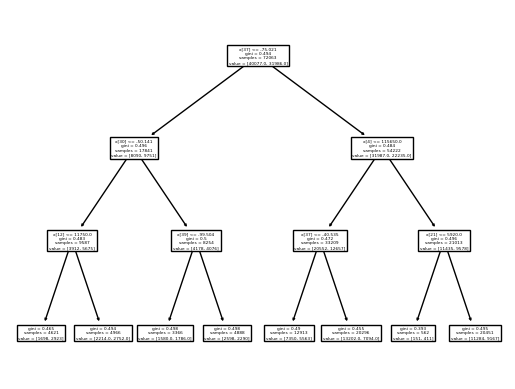

In [21]:
tree.plot_tree(tree_clf)

Model AUC: 0.5462122904333461


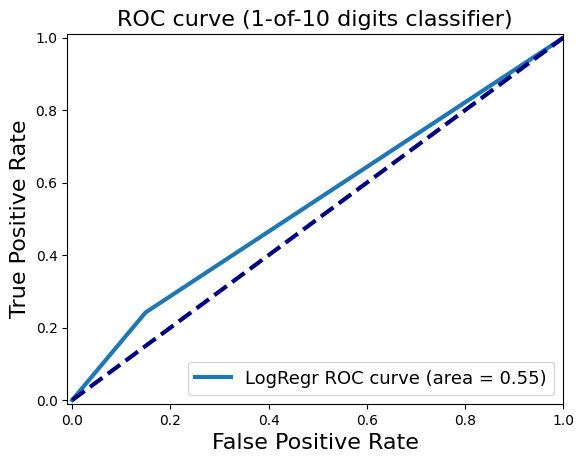

In [22]:
fpr_lr, tpr_lr, _ = roc_curve(y_test_3_days, tree_clf.predict(X_test_3_days))
roc_auc_lr = auc(fpr_lr, tpr_lr)
print("Model AUC:", roc_auc_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [23]:
cv_scores_df = cross_val_scores(tree_clf, X_test_3_days, y_test_3_days)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6760973275670475, -0.6784952316260906, -0....",-0.677
1,Accuracy,"[0.586015538290788, 0.5803497085761865, 0.5797...",0.580
2,Precision,"[0.5767045454545454, 0.5535055350553506, 0.551...",0.559
3,Recall,"[0.25375, 0.28142589118198874, 0.2845528455284...",0.262
4,F1,"[0.3524305555555556, 0.373134328358209, 0.3754...",0.356
5,Roc_auc,"[0.5835563248502994, 0.5745271495782668, 0.572...",0.578


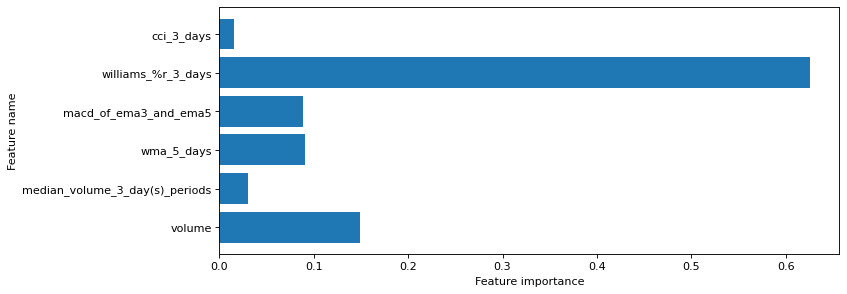

Feature importances: [0.14864696 0.03045219 0.09076676 0.08844243 0.62576927 0.01592238]


In [24]:
feature_importances = tree_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X_3_days.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))

In [25]:
tree_clf = DecisionTreeClassifier(max_depth=3).fit(X_train_4_days, y_train_4_days)
print_model_evaluation_metrics(tree_clf, X_train_4_days, y_train_4_days, X_test_4_days, y_test_4_days)
cv_scores_df = cross_val_scores(tree_clf, X_test_4_days, y_test_4_days)
cv_scores_df

Train Accuracy: 0.581
Test Accuracy: 0.575
Train AUC: 0.564
Test AUC: 0.558
Test Log Loss: 0.676
Classification Report:
              precision    recall  f1-score   support

       not 1       0.59      0.73      0.65      9733
           1       0.54      0.39      0.45      7919

    accuracy                           0.57     17652
   macro avg       0.56      0.56      0.55     17652
weighted avg       0.57      0.57      0.56     17652



,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6783889739488613, -0.6778083162305807, -0....",-0.678
1,Accuracy,"[0.5783064287737185, 0.5811384876805438, 0.582...",0.582
2,Precision,"[0.5571600481347774, 0.5382932166301969, 0.544...",0.553
3,Recall,"[0.2922979797979798, 0.4659090909090909, 0.416...",0.370
4,F1,"[0.38343685300207037, 0.49949238578680205, 0.4...",0.440
5,Roc_auc,"[0.578792061602154, 0.5809340516100917, 0.5703...",0.580


In [26]:
tree_clf = DecisionTreeClassifier(max_depth=3).fit(X_train_5_days, y_train_5_days)
print_model_evaluation_metrics(tree_clf, X_train_5_days, y_train_5_days, X_test_5_days, y_test_5_days)
cv_scores_df = cross_val_scores(tree_clf, X_test_5_days, y_test_5_days)
cv_scores_df

Train Accuracy: 0.581
Test Accuracy: 0.573
Train AUC: 0.577
Test AUC: 0.569
Test Log Loss: 0.677
Classification Report:
              precision    recall  f1-score   support

       not 1       0.60      0.62      0.61      9571
           1       0.54      0.52      0.53      8110

    accuracy                           0.57     17681
   macro avg       0.57      0.57      0.57     17681
weighted avg       0.57      0.57      0.57     17681



,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6789009625299978, -0.6791019286881065, -0....",-0.678
1,Accuracy,"[0.5750636132315522, 0.5709841628959276, 0.561...",0.573
2,Precision,"[0.5802968960863698, 0.5437864887406172, 0.528...",0.568
3,Recall,"[0.2651048088779285, 0.40197287299630086, 0.40...",0.319
4,F1,"[0.36394413880660176, 0.46224742998936547, 0.4...",0.402
5,Roc_auc,"[0.5812968227343993, 0.581609227613522, 0.5683...",0.584


# Random Forest

In [27]:
forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train_3_days, y_train_3_days)

print_model_evaluation_metrics(forest_clf, X_train_3_days, y_train_3_days, X_test_3_days, y_test_3_days)

Train Accuracy: 1.000
Test Accuracy: 0.599
Train AUC: 1.000
Test AUC: 0.578
Test Log Loss: 0.664
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.77      0.68     10019
           1       0.57      0.39      0.46      7997

    accuracy                           0.60     18016
   macro avg       0.59      0.58      0.57     18016
weighted avg       0.59      0.60      0.58     18016



In [86]:
# forest_clf = RandomForestClassifier(random_state=0)
# grid_values = {
#     'n_estimators': [5, 10, 15, 20, 50, 60, 75, 100],
#     'max_depth': range(10, 21, 2),
#     'max_features': range(10, 21, 2)
# }

# grid_clf_auc = GridSearchCV(forest_clf, param_grid = grid_values, scoring = 'roc_auc')
# grid_clf_auc.fit(X_train, y_train)
# y_decision_fn_scores_auc = grid_clf_auc.predict(X_test) 

# print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
# print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
# print('Grid best score (AUC): ', grid_clf_auc.best_score_)

In [28]:
forest_clf = RandomForestClassifier(random_state=0)
grid_values = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search_cv = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=grid_values,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42
)
random_search_cv.fit(X_train_3_days, y_train_3_days)

print(random_search_cv.best_estimator_)
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/

RandomForestClassifier(max_depth=15, max_features='log2', n_estimators=150,
                       random_state=0)
{'n_estimators': 150, 'max_features': 'log2', 'max_depth': 15}
0.6303654204976477


In [29]:
# forest_clf = RandomForestClassifier(n_estimators=10, max_features=18, max_depth=8, random_state=0)
forest_clf = random_search_cv.best_estimator_
forest_clf.fit(X_train_3_days, y_train_3_days)

print_model_evaluation_metrics(forest_clf, X_train_3_days, y_train_3_days, X_test_3_days, y_test_3_days)

Train Accuracy: 0.862
Test Accuracy: 0.604
Train AUC: 0.847
Test AUC: 0.577
Test Log Loss: 0.660
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.82      0.70     10019
           1       0.60      0.34      0.43      7997

    accuracy                           0.60     18016
   macro avg       0.60      0.58      0.56     18016
weighted avg       0.60      0.60      0.58     18016



In [31]:
cv_scores_df = cross_val_scores(forest_clf, X_3_days, y_3_days)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6597078137165734, -0.6602382729182128, -0....",-0.660
1,Accuracy,"[0.6050177619893428, 0.6021314387211367, 0.609...",0.603
2,Precision,"[0.5981724983285046, 0.5863721608668473, 0.603...",0.593
3,Recall,"[0.3356258596973865, 0.35188195573340003, 0.34...",0.337
4,F1,"[0.4299903876962512, 0.43982494529540483, 0.44...",0.430
5,Roc_auc,"[0.6315011107506466, 0.6269277942997464, 0.634...",0.628


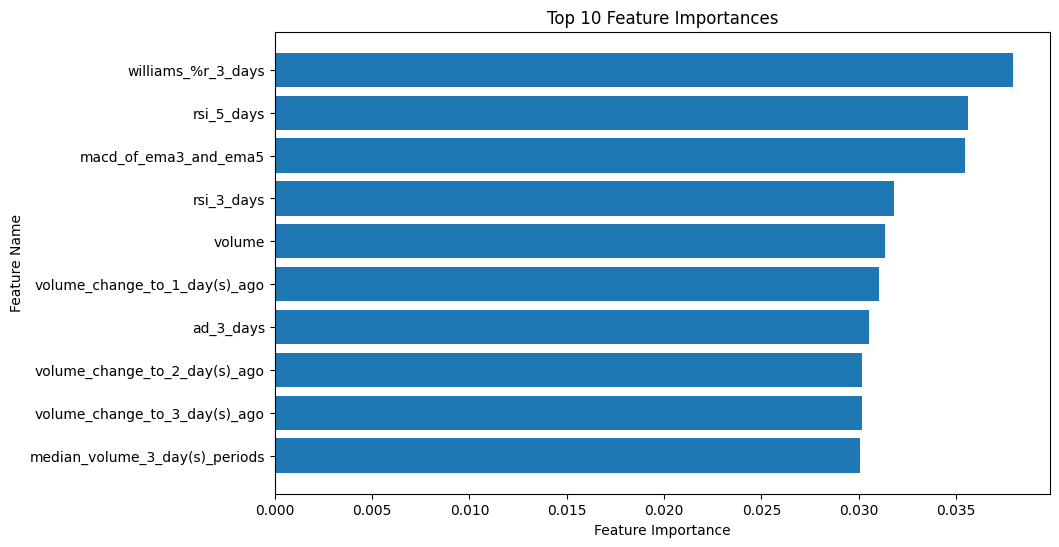

Top 10 Feature Importances:
williams_%r_3_days: 0.03792019923599436
rsi_5_days: 0.03559500207071558
macd_of_ema3_and_ema5: 0.03547428998160194
rsi_3_days: 0.03183716424693552
volume: 0.03132494351521554
volume_change_to_1_day(s)_ago: 0.031068051688463282
ad_3_days: 0.03055043863078295
volume_change_to_2_day(s)_ago: 0.03019237923973866
volume_change_to_3_day(s)_ago: 0.030150882756897642
median_volume_3_day(s)_periods: 0.030064156649975603


In [32]:
feature_importances = forest_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X_3_days.columns[non_zero_indices]

sorted_indices = np.argsort(non_zero_importances)[::-1]
top_10_indices = sorted_indices[:10]

top_10_importances = non_zero_importances[top_10_indices]
top_10_feature_names = non_zero_feature_names[top_10_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_importances)), top_10_importances, align='center')
plt.yticks(np.arange(len(top_10_importances)), top_10_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

print('Top 10 Feature Importances:')
for feature, importance in zip(top_10_feature_names, top_10_importances):
    print(f'{feature}: {importance}')

In [33]:
forest_clf = RandomForestClassifier(random_state=0)
grid_values = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search_cv = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=grid_values,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42
)
random_search_cv.fit(X_train_4_days, y_train_4_days)

print(random_search_cv.best_estimator_)
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/

RandomForestClassifier(max_depth=15, max_features='log2', n_estimators=150,
                       random_state=0)
{'n_estimators': 150, 'max_features': 'log2', 'max_depth': 15}
0.632404676362621


In [34]:
forest_clf = random_search_cv.best_estimator_
forest_clf.fit(X_train_4_days, y_train_4_days)

print_model_evaluation_metrics(forest_clf, X_train_4_days, y_train_4_days, X_test_4_days, y_test_4_days)
cv_scores_df = cross_val_scores(forest_clf, X_4_days, y_4_days)
cv_scores_df

Train Accuracy: 0.877
Test Accuracy: 0.606
Train AUC: 0.867
Test AUC: 0.585
Test Log Loss: 0.659
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.78      0.69      9733
           1       0.59      0.39      0.47      7919

    accuracy                           0.61     17652
   macro avg       0.60      0.59      0.58     17652
weighted avg       0.60      0.61      0.59     17652



,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6621345208541536, -0.6587577639296283, -0....",-0.660
1,Accuracy,"[0.5954566054837979, 0.6072966236120553, 0.598...",0.600
2,Precision,"[0.5749807247494217, 0.5897762415863198, 0.581...",0.582
3,Recall,"[0.37668897588079303, 0.40939512564717767, 0.3...",0.383
4,F1,"[0.45517662317845425, 0.4833035181872391, 0.45...",0.462
5,Roc_auc,"[0.6261085686659416, 0.6337811887018447, 0.634...",0.630


In [35]:
forest_clf = RandomForestClassifier(random_state=0)
grid_values = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search_cv = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=grid_values,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42
)
random_search_cv.fit(X_train_5_days, y_train_5_days)

print(random_search_cv.best_estimator_)
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/

RandomForestClassifier(max_depth=15, max_features='log2', n_estimators=150,
                       random_state=0)
{'n_estimators': 150, 'max_features': 'log2', 'max_depth': 15}
0.6384344231718269


In [36]:
forest_clf = random_search_cv.best_estimator_
forest_clf.fit(X_train_5_days, y_train_5_days)

print_model_evaluation_metrics(forest_clf, X_train_5_days, y_train_5_days, X_test_5_days, y_test_5_days)
cv_scores_df = cross_val_scores(forest_clf, X_5_days, y_5_days)
cv_scores_df

Train Accuracy: 0.880
Test Accuracy: 0.602
Train AUC: 0.874
Test AUC: 0.589
Test Log Loss: 0.660
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.74      0.67      9571
           1       0.59      0.44      0.50      8110

    accuracy                           0.60     17681
   macro avg       0.60      0.59      0.59     17681
weighted avg       0.60      0.60      0.59     17681



,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6645202620733136, -0.6622129422525392, -0....",-0.662
1,Accuracy,"[0.5922176347491658, 0.5989480233018495, 0.608...",0.598
2,Precision,"[0.5764266304347826, 0.5814027799968046, 0.599...",0.585
3,Recall,"[0.4184956843403206, 0.44870530209617754, 0.44...",0.429
4,F1,"[0.4849264180597228, 0.5065070638179414, 0.508...",0.495
5,Roc_auc,"[0.6250134983131457, 0.6307651710926491, 0.643...",0.631


OOB score

n_estimators    Train Score     OOB Score


/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10              0.8205          0.6189


/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


20              0.8428          0.6396
30              0.8530          0.6468
40              0.8577          0.6519
50              0.8614          0.6556
60              0.8620          0.6566
70              0.8619          0.6600
80              0.8633          0.6615
90              0.8639          0.6629
100             0.8643          0.6650
110             0.8637          0.6663
120             0.8654          0.6680
130             0.8662          0.6677
140             0.8656          0.6691
150             0.8660          0.6693
160             0.8661          0.6689
170             0.8668          0.6682
180             0.8661          0.6703
190             0.8663          0.6718
200             0.8660          0.6710


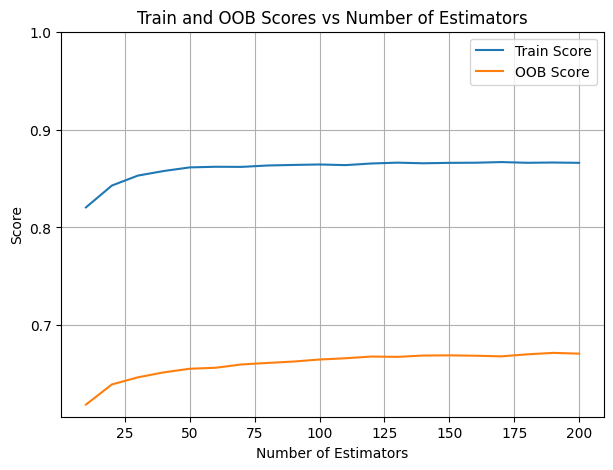

In [70]:
# forest_clf_demo = RandomForestClassifier(oob_score=True, random_state=0)
# n_estimators_range = range(10, 210, 10)

# train_scores = []
# oob_scores_val = []

# print(f"{'n_estimators':<15} {'Train Score':<15} {'OOB Score'}")
# for n_estimators in n_estimators_range:
#     forest_clf_demo.set_params(n_estimators=n_estimators, max_depth=20, min_samples_leaf=10)
#     forest_clf_demo.fit(X_train, y_train)

#     train_score = forest_clf_demo.score(X_train, y_train)
#     train_scores.append(train_score)
    
#     oob_score_val = forest_clf_demo.oob_score_
#     oob_scores_val.append(oob_score_val)

#     print(f"{n_estimators:<15} {train_score:<15.4f} {oob_score_val:.4f}")

# plt.figure(figsize=(7, 5))
# plt.plot(n_estimators_range, train_scores, label='Train Score')
# plt.plot(n_estimators_range, oob_scores_val, label='OOB Score')
# plt.xlabel('Number of Estimators')
# plt.ylabel('Score')
# plt.title('Train and OOB Scores vs Number of Estimators')
# plt.yticks(np.arange(0.7, 1, 0.1))
# plt.legend()
# plt.grid(True)
# plt.show()

## XGBoost

In [37]:
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)
xgb_clf.fit(X_train_3_days, y_train_3_days, early_stopping_rounds=5, eval_set=[(X_test_3_days, y_test_3_days)])
print_model_evaluation_metrics(xgb_clf, X_train_3_days, y_train_3_days, X_test_3_days, y_test_3_days)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67821
[1]	validation_0-logloss:0.67343
[2]	validation_0-logloss:0.66964
[3]	validation_0-logloss:0.66701
[4]	validation_0-logloss:0.66514
[5]	validation_0-logloss:0.66400
[6]	validation_0-logloss:0.66341
[7]	validation_0-logloss:0.66287
[8]	validation_0-logloss:0.66247
[9]	validation_0-logloss:0.66242
[10]	validation_0-logloss:0.66185
[11]	validation_0-logloss:0.66183
[12]	validation_0-logloss:0.66161
[13]	validation_0-logloss:0.66161
[14]	validation_0-logloss:0.66150
[15]	validation_0-logloss:0.66177
[16]	validation_0-logloss:0.66175
[17]	validation_0-logloss:0.66156
[18]	validation_0-logloss:0.66147
[19]	validation_0-logloss:0.66151
[20]	validation_0-logloss:0.66168
[21]	validation_0-logloss:0.66174
[22]	validation_0-logloss:0.66190
Train Accuracy: 0.650
Test Accuracy: 0.603
Train AUC: 0.629
Test AUC: 0.580
Test Log Loss: 0.661
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.78      0.69     10019

In [38]:
cv_scores_df = cross_val_scores(xgb_clf, X_3_days, y_3_days)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6690962350953663, -0.6710997592444992, -0....",-0.670
1,Accuracy,"[0.5936389875666075, 0.5950821492007105, 0.603...",0.596
2,Precision,"[0.5557571758495546, 0.5553453169347209, 0.570...",0.560
3,Recall,"[0.42128298111791923, 0.44041515568338124, 0.4...",0.422
4,F1,"[0.4792659506366029, 0.49124764627937795, 0.48...",0.481
5,Roc_auc,"[0.6190415402182646, 0.6181330562590075, 0.624...",0.620


In [39]:
params = {
    "gamma": uniform(0, 0.9),
    "learning_rate": uniform(0.01, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": [20, 50, 100, 150], # default 100
}

search = RandomizedSearchCV(xgb_clf, param_distributions=params, random_state=0, n_iter=200, cv=5, scoring='roc_auc')

search.fit(X_3_days, y_3_days)

print(search.best_estimator_)
print(search.best_params_)
print(search.best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.44141292775581037, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07822438839199697,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)
{'gamma': 0.44141292775581037, 'learning_rate': 0.07822438839199697, 'max_depth': 5, 'n_estimators': 150}
0.6324372674104092


In [40]:
# xgb_clf = search.best_estimator_
params = {
    'gamma': 0.44141292775581037, 
    'learning_rate': 0.13333333333333333, 
    'max_depth': 5, 
    'n_estimators': 150,
}

xgb_clf = XGBClassifier(**params, eval_metric='auc', booster='gbtree')

xgb_clf.fit(X_train_3_days, y_train_3_days, eval_set=[(X_test_3_days, y_test_3_days)])

[0]	validation_0-auc:0.58874
[1]	validation_0-auc:0.59441
[2]	validation_0-auc:0.59952
[3]	validation_0-auc:0.60236
[4]	validation_0-auc:0.60454
[5]	validation_0-auc:0.60856
[6]	validation_0-auc:0.61075
[7]	validation_0-auc:0.61178
[8]	validation_0-auc:0.61349
[9]	validation_0-auc:0.61480
[10]	validation_0-auc:0.61570
[11]	validation_0-auc:0.61595
[12]	validation_0-auc:0.61710
[13]	validation_0-auc:0.61751
[14]	validation_0-auc:0.61774
[15]	validation_0-auc:0.61874
[16]	validation_0-auc:0.61936
[17]	validation_0-auc:0.62004
[18]	validation_0-auc:0.62054
[19]	validation_0-auc:0.62112
[20]	validation_0-auc:0.62126
[21]	validation_0-auc:0.62168
[22]	validation_0-auc:0.62200
[23]	validation_0-auc:0.62216
[24]	validation_0-auc:0.62282
[25]	validation_0-auc:0.62319
[26]	validation_0-auc:0.62371
[27]	validation_0-auc:0.62419
[28]	validation_0-auc:0.62462
[29]	validation_0-auc:0.62496
[30]	validation_0-auc:0.62504
[31]	validation_0-auc:0.62537
[32]	validation_0-auc:0.62543
[33]	validation_0-au

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.44141292775581037, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13333333333333333,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
print_model_evaluation_metrics(xgb_clf, X_train_3_days, y_train_3_days, X_test_3_days, y_test_3_days)

Train Accuracy: 0.677
Test Accuracy: 0.608
Train AUC: 0.657
Test AUC: 0.585
Test Log Loss: 0.659
Classification Report:
              precision    recall  f1-score   support

       not 1       0.62      0.78      0.69     10019
           1       0.59      0.39      0.47      7997

    accuracy                           0.61     18016
   macro avg       0.60      0.59      0.58     18016
weighted avg       0.60      0.61      0.59     18016



In [42]:
cv_scores_df = cross_val_scores(xgb_clf, X_3_days, y_3_days)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.659334347641136, -0.659069530116427, -0.65...",-0.659
1,Accuracy,"[0.6062388987566607, 0.6041851687388987, 0.610...",0.605
2,Precision,"[0.5852691218130311, 0.575991575991576, 0.5916...",0.583
3,Recall,"[0.387520320120045, 0.41040390146304867, 0.397...",0.389
4,F1,"[0.4662955160999097, 0.4792990142387733, 0.475...",0.467
5,Roc_auc,"[0.6317248135133218, 0.6310906177100573, 0.637...",0.632


Learning Rate with Closest AUC and Log Loss: 0.10666666666666667


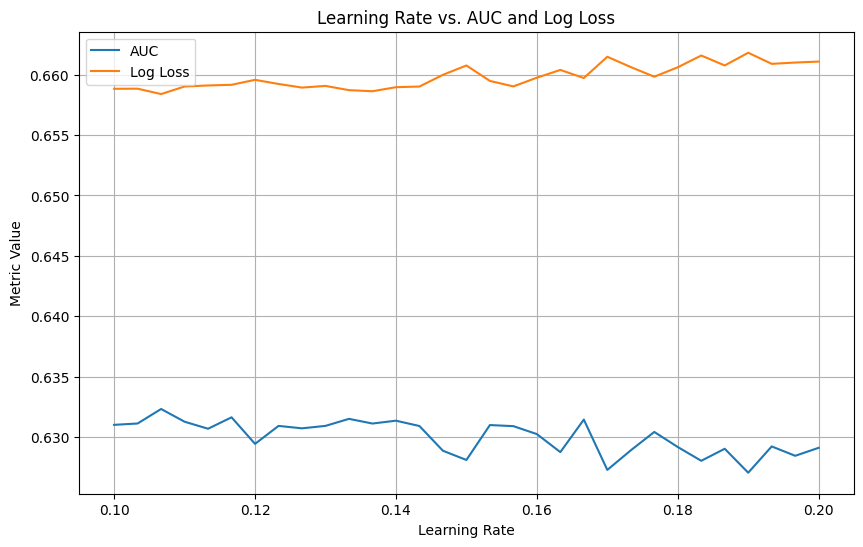

In [43]:
def find_best_learning_rate(X_train, y_train, X_test, y_test, base_params, learning_rates):
    best_lr = None
    min_diff = float('inf')
    auc_values = []
    log_loss_values = []

    for lr in learning_rates:
        params = base_params.copy()
        params['learning_rate'] = lr

        xgb_clf = XGBClassifier(**params)
        xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

        y_pred_proba = xgb_clf.predict_proba(X_test)

        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        auc_values.append(auc)

        logloss = log_loss(y_test, y_pred_proba)
        log_loss_values.append(logloss)

        diff = abs(auc - logloss)

        if diff < min_diff:
            min_diff = diff
            best_lr = lr

    print("Learning Rate with Closest AUC and Log Loss:", best_lr)

    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, auc_values, label='AUC')
    plt.plot(learning_rates, log_loss_values, label='Log Loss')
    plt.xlabel('Learning Rate')
    plt.ylabel('Metric Value')
    plt.title('Learning Rate vs. AUC and Log Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
learning_rates = np.linspace(0.1, 0.2, 31)

base_params = {
    'gamma': 0.44141292775581037, 
    'max_depth': 5, 
    'n_estimators': 150,
    'eval_metric': 'auc'
}

find_best_learning_rate(X_train_3_days, y_train_3_days, X_test_3_days, y_test_3_days, base_params, learning_rates)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

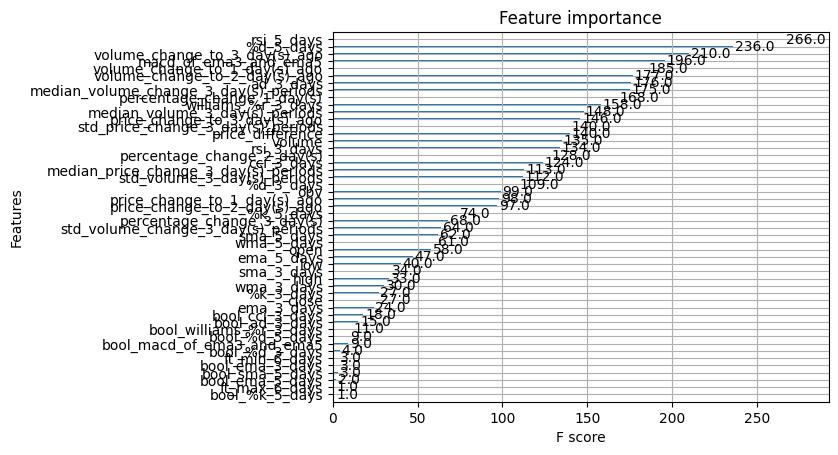

In [44]:
plot_importance(xgb_clf)

In [45]:
# xgb_clf = search.best_estimator_
params = {
    'gamma': 0.44141292775581037, 
    'learning_rate': 0.13333333333333333, 
    'max_depth': 5, 
    'n_estimators': 150,
}

xgb_clf = XGBClassifier(**params, eval_metric='auc', booster='gbtree')

xgb_clf.fit(X_train_4_days, y_train_4_days, eval_set=[(X_test_4_days, y_test_4_days)])
print_model_evaluation_metrics(xgb_clf, X_train_4_days, y_train_4_days, X_test_4_days, y_test_4_days)
cv_scores_df = cross_val_scores(xgb_clf, X_4_days, y_4_days)
cv_scores_df

[0]	validation_0-auc:0.60027
[1]	validation_0-auc:0.60632
[2]	validation_0-auc:0.61335
[3]	validation_0-auc:0.61623
[4]	validation_0-auc:0.61713
[5]	validation_0-auc:0.61851
[6]	validation_0-auc:0.61952
[7]	validation_0-auc:0.62034
[8]	validation_0-auc:0.62173
[9]	validation_0-auc:0.62244
[10]	validation_0-auc:0.62281
[11]	validation_0-auc:0.62340
[12]	validation_0-auc:0.62367
[13]	validation_0-auc:0.62442
[14]	validation_0-auc:0.62502
[15]	validation_0-auc:0.62576
[16]	validation_0-auc:0.62640
[17]	validation_0-auc:0.62701
[18]	validation_0-auc:0.62751
[19]	validation_0-auc:0.62743
[20]	validation_0-auc:0.62792
[21]	validation_0-auc:0.62817
[22]	validation_0-auc:0.62897
[23]	validation_0-auc:0.62949
[24]	validation_0-auc:0.62985
[25]	validation_0-auc:0.62990
[26]	validation_0-auc:0.62998
[27]	validation_0-auc:0.63063
[28]	validation_0-auc:0.63066
[29]	validation_0-auc:0.63120
[30]	validation_0-auc:0.63120
[31]	validation_0-auc:0.63108
[32]	validation_0-auc:0.63132
[33]	validation_0-au

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.66125894239851, -0.6593025507432982, -0.65...",-0.660
1,Accuracy,"[0.6007251302968503, 0.6050872422388398, 0.601...",0.602
2,Precision,"[0.5776707686820046, 0.5780375370431347, 0.577...",0.579
3,Recall,"[0.4090162899355979, 0.44336406111882815, 0.41...",0.416
4,F1,"[0.47892946917048645, 0.5018223397412992, 0.48...",0.484
5,Roc_auc,"[0.628703928675144, 0.6340606998889545, 0.6372...",0.632


In [46]:
# xgb_clf = search.best_estimator_
params = {
    'gamma': 0.44141292775581037, 
    'learning_rate': 0.13333333333333333, 
    'max_depth': 5, 
    'n_estimators': 150,
}

xgb_clf = XGBClassifier(**params, eval_metric='auc', booster='gbtree')

xgb_clf.fit(X_train_5_days, y_train_5_days, eval_set=[(X_test_5_days, y_test_5_days)])
print_model_evaluation_metrics(xgb_clf, X_train_5_days, y_train_5_days, X_test_5_days, y_test_5_days)
cv_scores_df = cross_val_scores(xgb_clf, X_5_days, y_5_days)
cv_scores_df

[0]	validation_0-auc:0.60380
[1]	validation_0-auc:0.60702
[2]	validation_0-auc:0.61102
[3]	validation_0-auc:0.61259
[4]	validation_0-auc:0.61426
[5]	validation_0-auc:0.61521
[6]	validation_0-auc:0.61620
[7]	validation_0-auc:0.61725
[8]	validation_0-auc:0.61839
[9]	validation_0-auc:0.61932
[10]	validation_0-auc:0.62014
[11]	validation_0-auc:0.62116
[12]	validation_0-auc:0.62244
[13]	validation_0-auc:0.62324
[14]	validation_0-auc:0.62373
[15]	validation_0-auc:0.62434
[16]	validation_0-auc:0.62519
[17]	validation_0-auc:0.62560
[18]	validation_0-auc:0.62649
[19]	validation_0-auc:0.62699
[20]	validation_0-auc:0.62749
[21]	validation_0-auc:0.62782
[22]	validation_0-auc:0.62828
[23]	validation_0-auc:0.62791
[24]	validation_0-auc:0.62845
[25]	validation_0-auc:0.62849
[26]	validation_0-auc:0.62880
[27]	validation_0-auc:0.62913
[28]	validation_0-auc:0.62918
[29]	validation_0-auc:0.62959
[30]	validation_0-auc:0.62949
[31]	validation_0-auc:0.62972
[32]	validation_0-auc:0.62980
[33]	validation_0-au

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6634207268416, -0.6606537376044268, -0.656...",-0.661
1,Accuracy,"[0.598552118092868, 0.6033595384876421, 0.6095...",0.602
2,Precision,"[0.5805732484076433, 0.5832195417994235, 0.596...",0.585
3,Recall,"[0.4495684340320592, 0.4739827373612824, 0.460...",0.452
4,F1,"[0.5067407922168172, 0.5229576219304809, 0.519...",0.510
5,Roc_auc,"[0.6287789962511342, 0.6346320142755533, 0.644...",0.634


# Additional Models
## AdaBoost

In [46]:
X_no_nan_train = X_train.replace(np.nan, None)
X_no_nan_test = X_test.replace(np.nan, None)

In [50]:
ada_boost_dt_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=0), 
    n_estimators=5, 
    learning_rate=0.04,
    random_state=0)

ada_boost_dt_classifier.fit(X_no_nan_train, y_train)
print_model_evaluation_metrics(ada_boost_dt_classifier, X_no_nan_train, y_train, X_no_nan_test, y_test)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Accuracy: 0.585
Test Accuracy: 0.586
Train AUC: 0.548
Test AUC: 0.549
Test Log Loss: 0.673
Classification Report:
              precision    recall  f1-score   support

       not 1       0.59      0.88      0.70     12524
           1       0.59      0.22      0.32      9996

    accuracy                           0.59     22520
   macro avg       0.59      0.55      0.51     22520
weighted avg       0.59      0.59      0.53     22520



In [51]:
X_no_nan = X.replace(np.nan, None)
cv_scores_df = cross_val_scores(ada_boost_dt_classifier, X_no_nan, y)
cv_scores_df

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarn

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6751290624114353, -0.6725634854412731, -0....",-0.674
1,Accuracy,"[0.582648756660746, 0.5878663410301954, 0.5790...",0.585
2,Precision,"[0.5681688533941814, 0.5787011557512383, 0.557...",0.576
3,Recall,"[0.2490934100287608, 0.26297361510566464, 0.25...",0.248
4,F1,"[0.3463444318873337, 0.36161980913077124, 0.34...",0.346
5,Roc_auc,"[0.5855686500263728, 0.5910328272992581, 0.578...",0.588


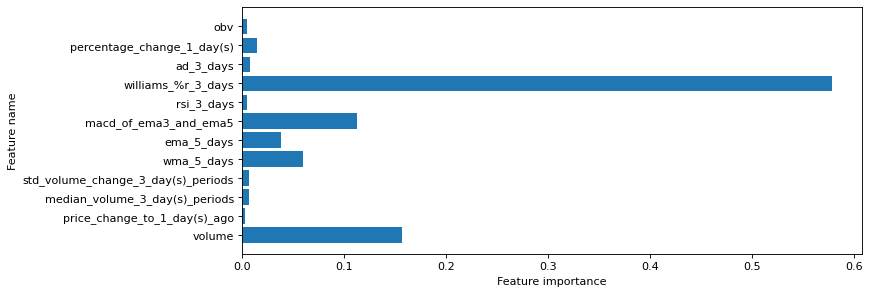

Feature importances: [0.15748466 0.00358022 0.00696866 0.00750984 0.0603914  0.03891846
 0.11282371 0.00542388 0.5787443  0.00842033 0.01471879 0.00501574]


In [55]:
feature_importances = ada_boost_dt_classifier.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))

## LightGBM

In [56]:
lgbm_clf = LGBMClassifier(objective='binary')
lgbm_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
print_model_evaluation_metrics(lgbm_clf, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 29987, number of negative: 37572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 67559, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443864 -> initscore=-0.225495
[LightGBM] [Info] Start training from score -0.225495
Train Accuracy: 0.663
Test Accuracy: 0.609
Train AUC: 0.641
Test AUC: 0.585
Test Log Loss: 0.657
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.80      0.69     12524
           1       0.60      0.37      0.46      9996

    accuracy                           0.61     22520
   macro avg       0.61      0.59      0.58     22520
weighted avg       0.61      0.61      0.59     22

In [54]:
cv_scores_df = cross_val_scores(lgbm_clf, X, y)
cv_scores_df

[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443862 -> initscore=-0.225504
[LightGBM] [Info] Start training from score -0.225504
[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] 

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6594046318541675, -0.6578765138953705, -0....",-0.659
1,Accuracy,"[0.6054063055062167, 0.6066274422735346, 0.609...",0.605
2,Precision,"[0.5896607431340872, 0.5859138972809668, 0.596...",0.589
3,Recall,"[0.36513692634738026, 0.3880205076903839, 0.37...",0.369
4,F1,"[0.45100007722604063, 0.4668622583314526, 0.46...",0.453
5,Roc_auc,"[0.6305543663612851, 0.6330883787978032, 0.638...",0.632


In [122]:
param_dist = {
    'n_estimators': range(80, 101)
}

lgbm_clf = LGBMClassifier(objective='binary', num_leaves=2, max_depth=1, learning_rate=0.018)

random_search = GridSearchCV(lgbm_clf, param_grid=param_dist, cv=5, scoring='roc_auc')

random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

[LightGBM] [Info] Number of positive: 100, number of negative: 143
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411523 -> initscore=-0.357674
[LightGBM] [Info] Start training from score -0.357674
[LightGBM] [Info] Number of positive: 101, number of negative: 142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 55
[LightGBM] [Info] [binary:Boos

In [57]:
lgbm_clf = LGBMClassifier(
    objective='binary',
    n_estimators=88,
    num_leaves=2,
    max_depth=1,
    learning_rate=0.018
)
lgbm_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Info] Number of positive: 29987, number of negative: 37572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 67559, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443864 -> initscore=-0.225495
[LightGBM] [Info] Start training from score -0.225495


LGBMClassifier(learning_rate=0.018, max_depth=1, n_estimators=88, num_leaves=2,
               objective='binary')

In [58]:
print_model_evaluation_metrics(lgbm_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.579
Test Accuracy: 0.581
Train AUC: 0.538
Test AUC: 0.540
Test Log Loss: 0.678
Classification Report:
              precision    recall  f1-score   support

       not 1       0.58      0.91      0.71     12524
           1       0.60      0.17      0.27      9996

    accuracy                           0.58     22520
   macro avg       0.59      0.54      0.49     22520
weighted avg       0.59      0.58      0.51     22520



In [59]:
cv_scores_df = cross_val_scores(lgbm_clf, X, y)
cv_scores_df

[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443862 -> initscore=-0.225504
[LightGBM] [Info] Start training from score -0.225504
[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] 

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6789084274517703, -0.6790669854135297, -0....",-0.679
1,Accuracy,"[0.5763210479573713, 0.5820381882770871, 0.578...",0.580
2,Precision,"[0.5749588138385503, 0.5976578837306566, 0.585...",0.589
3,Recall,"[0.1745654620482681, 0.17869200950356384, 0.17...",0.177
4,F1,"[0.2678177458033573, 0.2751251443973816, 0.264...",0.272
5,Roc_auc,"[0.5822107184794556, 0.5787457001635619, 0.580...",0.583


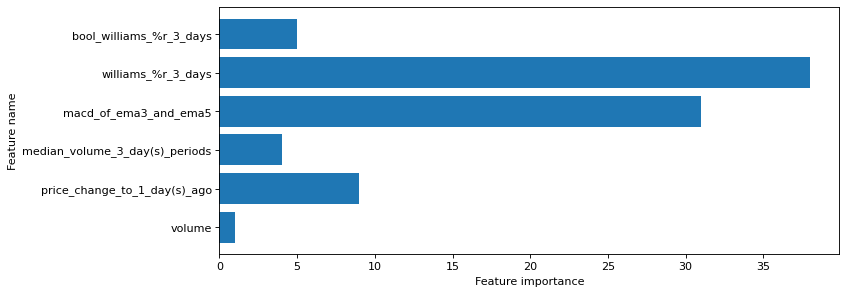

Feature importances: [ 1  9  4 31 38  5]


In [60]:
feature_importances = lgbm_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))